In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import matplotlib
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '025deg_abs', '01deg']


In [17]:
#PV_DS.to_netcdf('PV_ds_whole_eac')
#pv_ds_mf.to_netcdf('pv_ds_mean_eac')
pv_ds_var.to_netcdf('PV_ds_var_eac')

In [3]:
PV_DS=xr.open_dataarray('PV_ds_whole_eac')
pv_ds_mf=xr.open_dataarray('pv_ds_mean_eac')
pv_ds_var=xr.open_dataarray('PV_ds_var_eac')

In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
land = cft.NaturalEarthFeature('physical','land','110m',edgecolor='black',facecolor='gray',linewidth=0.5)

font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

In [6]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

## Downstream PV (whole)
\begin{equation}
\overline{\frac{u}{|u|} \cdot \nabla q}
\end{equation} or
\begin{equation}
\overline{\textbf{u}\cdot\nabla q}
\end{equation}

\begin{equation}
\overline{\textbf{u}\cdot\nabla q}=\overline{u\frac{\partial q}{\partial x}+v\frac{\partial q}{\partial y}+w \frac{\partial q}{\partial z}}
\end{equation}

In [22]:
def meands_pv(time):
    u = cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=eacx)\
                                 .sel(yu_ocean=eacy)\
                                 .sel(time=time)
    v = cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=eacx)\
                                 .sel(yu_ocean=eacy)\
                                 .sel(time=time)
    w=cc.get_nc_variable(expt,'ocean.nc','wt',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=eacx)\
                                 .sel(yt_ocean=eacy)\
                                 .sel(time=time)
    pv = cc.get_nc_variable(expt,'ocean.nc','vert_pv',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=eacx)\
                                 .sel(yt_ocean=eacy)\
                                 .sel(time=time)
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxu=grid.dxu.sel(xu_ocean=eacx)\
            .sel(yu_ocean=eacy)
    dyu=grid.dyu.sel(xu_ocean=eacx)\
            .sel(yu_ocean=eacy)
    z=u.st_ocean.values
    xsize=pv.shape[3]#290
    ysize=pv.shape[2]#345
    zsize=pv.shape[1]#75
    dz=z[1:]-z[0:-1]
    dz1=dz[1:]+dz[0:-1]
    dzdz=np.tile(dz1,(ysize-2,xsize-2,1))
    dz3d=np.transpose(dzdz,(2,0,1))
    pv_ds=np.zeros((zsize-2,ysize-2,xsize-2))
    for i in range(0,len(u.time)):
        print('opening file',str(i+1),'in',str(len(u.time)))
        u1=u.isel(time=i)
        v1=v.isel(time=i)
        w1=w.isel(time=i)
        pv1=pv.isel(time=i)
        #u*(dq/dx)
        dq=pv1.values[:,1:-1,2:]-pv1.values[:,1:-1,0:-2]
        dxdx=dxu.values[:,1:-1]+dxu.values[:,2:]
        dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
        dx3d=np.tile(dxdx_snmean,(zsize,1,1))
        uu=1/2*(u1.values[:,:,1:-1]+u1.values[:,:,2:])
        uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
        udq_dx=uu_snmean*(dq/dx3d)
        Udq_dx=xr.DataArray(udq_dx,coords=[pv1['st_ocean'],pv1['yt_ocean'][1:-1],pv1['xt_ocean'][1:-1]])
        #v*(dq/dy)
        dqy=pv1.values[:,2:,0:-1]-pv1.values[:,0:-2,0:-1]
        dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
        dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
        vv=1/2*(v1.values[:,0:-1,:]+v1.values[:,1:,:])
        vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
        dy3d=np.tile(dy_wemean,(zsize,1,1))
        vdq_dy=vv_wemean*(dqy/dy3d)
        Vdq_dy=xr.DataArray(vdq_dy,coords=[pv1['st_ocean'],pv1['yt_ocean'][1:-1],pv1['xt_ocean'][0:-1]])
        #w*(dq/dz)
        wnew=w1[:,1:-1,1:-1]
        qz=pv1[:,1:-1,1:-1]
        #dqz=qz.values[1:,:,:]-qz.values[0:-1,:,:]
        dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
        #w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
        w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
        wdq_dz=w_mean[0:-1,:,:]*(dqz/dz3d)
        Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
        #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)
        pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
        pv_ds=pv_ds+pv_downstream.values/len(u.time)
    PV_DS=xr.DataArray(pv_ds,coords=[pv1['st_ocean'][1:-1],pv1['yt_ocean'][1:-1],pv1['xt_ocean'][1:-1]])
    return PV_DS

In [7]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

region=WBC['eac']['region']
eacx=WBC['eac']['x']
eacy=WBC['eac']['y']

time=slice('1999-01-01','2009-01-01')

PV_DS=meands_pv(tstart,tend)

Text(0.5, 1.0, 'section at 153E')

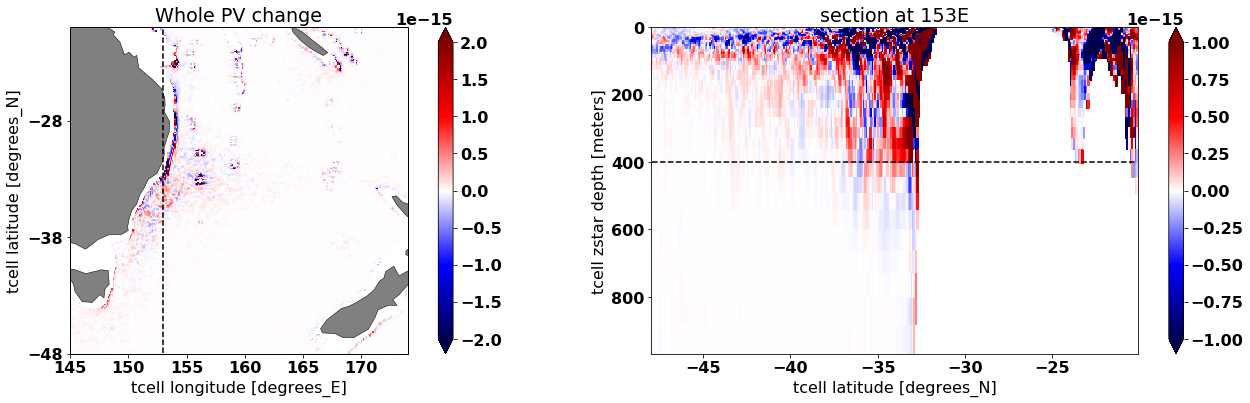

In [28]:
d=400
fig=plt.figure(figsize=(24,6))
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(eacx.start,eacx.stop+1,5)+360,crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(eacy.start,eacy.stop+1,10),crs=ccrs.PlateCarree())
PV_DS.sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmin=-2e-15,vmax=2e-15)
x0=PV_DS.sel(xt_ocean=153-360,method='nearest').xt_ocean.values
y0=PV_DS.yt_ocean.values
plt.plot(np.tile(x0+360,len(y0)),y0,'k--')
plt.title('Whole PV change')

ax=plt.subplot(1,2,2)
PV_DS.sel(xt_ocean=153-360,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=-1e-15,vmax=1e-15,yincrease=False)
plt.plot(y0,np.tile(d,len(y0)),'k--')
plt.title('section at 153E')

## downstream pv (mean flow)
\begin{equation}
\frac{\overline{u}}{|\overline{u}|} \cdot \nabla \overline{q}
\end{equation}

or

\begin{equation}
\begin{aligned}
&\overline{\textbf{u}} \cdot \nabla \overline{q}\
&=\overline{u}\frac{\partial\overline{q}}{\partial x}+\overline{v}\frac{\partial\overline{q}}{\partial y}+\overline{w}\frac{\partial\overline{q}}{\partial z}
\end{aligned}
\end{equation}

In [33]:
def meands_pv_mf(time):
    print('loading needed diags...')
    u = cc.get_nc_variable(expt,'ocean.nc','u',
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=eacx)\
                                 .sel(yu_ocean=eacy)\
                                 .sel(time=time).mean('time')
    v = cc.get_nc_variable(expt,'ocean.nc','v',
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=eacx)\
                                 .sel(yu_ocean=eacy)\
                                 .sel(time=time).mean('time')
    w=cc.get_nc_variable(expt,'ocean.nc','wt',
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=eacx)\
                                 .sel(yt_ocean=eacy)\
                                 .sel(time=time).mean('time')
    pv = cc.get_nc_variable(expt,'ocean.nc','vert_pv',
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=eacx)\
                                 .sel(yt_ocean=eacy)\
                                 .sel(time=time).mean('time')
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    xsize=pv.shape[3]#290
    ysize=pv.shape[2]#345
    zsize=pv.shape[1]#75
    dxu=grid.dxu.sel(xu_ocean=eacx)\
            .sel(yu_ocean=eacy)
    dyu=grid.dyu.sel(xu_ocean=eacx)\
            .sel(yu_ocean=eacy)
    z=u.st_ocean.values
    dz=z[1:]-z[0:-1]
    dzdz=dz[1:]+dz[0:-1]
    dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
    dz3d=np.transpose(dz3d,(2,0,1))
    #u*(dq/dx)
    print('computing udq_dx...')
    dq=pv.values[:,1:-1,2:]-pv.values[:,1:-1,0:-2]
    dxdx=dxu.values[:,1:-1]+dxu.values[:,2:]
    dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
    dx3d=np.tile(dxdx_snmean,(75,1,1))
    uu=1/2*(u.values[:,:,1:-1]+u.values[:,:,2:])
    uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
    udq_dx=uu_snmean*(dq/dx3d)
    Udq_dx=xr.DataArray(udq_dx,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    #v*(dq/dy)
    print('computing udq_dy...')
    dqy=pv.values[:,2:,0:-1]-pv.values[:,0:-2,0:-1]
    dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
    dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
    vv=1/2*(v.values[:,0:-1,:]+v.values[:,1:,:])
    vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
    dy3d=np.tile(dy_wemean,(zsize,1,1))
    vdq_dy=vv_wemean*(dqy/dy3d)
    Vdq_dy=xr.DataArray(vdq_dy,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][0:-1]])#(75, 343, 289)
    #w*(dq/dz)
    print('computing wdq_dz')
    wnew=w[:,1:-1,1:-1]
    qz=pv[:,1:-1,1:-1]
    dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
    w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
    wdq_dz=w_mean[0:-1,:,:]*(dqz/dz3d)
    Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
    #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)
    
    pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
    PV_DS=xr.DataArray(pv_downstream,coords=[pv['st_ocean'][1:-1],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    return PV_DS

In [31]:
warnings.filterwarnings('ignore')
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

region=WBC['eac']['region']
eacx=WBC['eac']['x']
eacy=WBC['eac']['y']

time=slice('1999-01-01','2009-01-01')
pv_ds_mf=meands_pv_mf(time)

In [36]:
warnings.filterwarnings('ignore')
U10=cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=eacx)\
                                 .sel(yu_ocean=eacy)\
                                 .sel(time=time).mean('time')
V10=cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=eacx)\
                                 .sel(yu_ocean=eacy)\
                                 .sel(time=time).mean('time')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Saving cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Saving cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl


Text(0, 0.5, 's$^{-4}$')

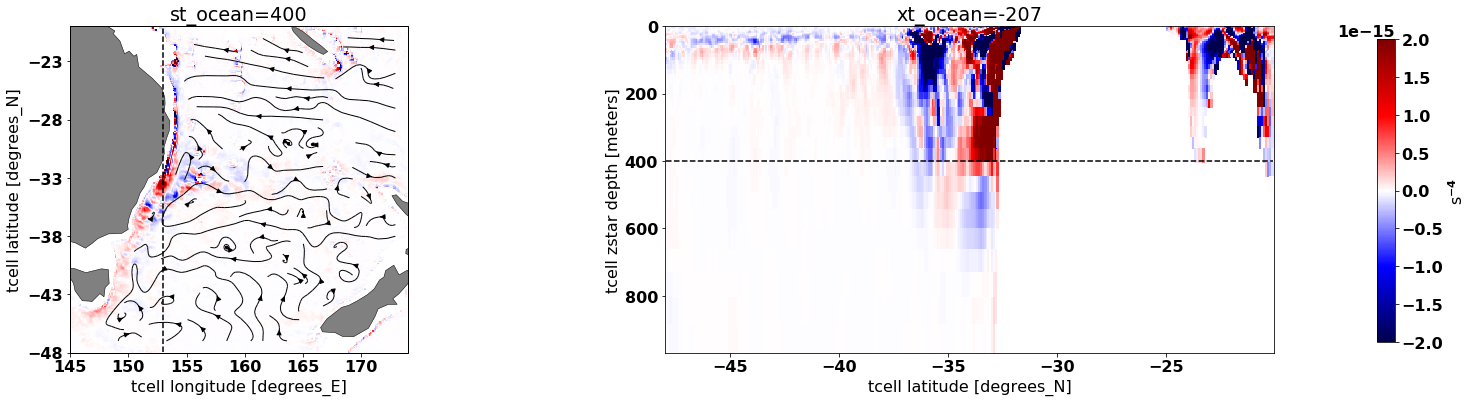

In [39]:
vmin=-2e-15
vmax=2e-15
d=400
U10_sl=U10.sel(st_ocean=d,method='nearest')
V10_sl=V10.sel(st_ocean=d,method='nearest')
X,Y=np.meshgrid(U10_sl['xu_ocean'].values+360,V10_sl['yu_ocean'].values)
fig=plt.figure(figsize=(24,6))
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_xticks(np.arange(eacx.start,eacx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(eacy.start,eacy.stop+1,5), crs=ccrs.PlateCarree())
ax.streamplot(X, Y, U10_sl.values, V10_sl.values,density=1,color='k',linewidth=1)
p1=pv_ds_mf.sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmin=vmin,vmax=vmax,add_colorbar=False)
x0=pv_ds_mf.sel(xt_ocean=153-360,method='nearest').xt_ocean.values
y0=pv_ds_mf.yt_ocean.values
plt.plot(np.tile(x0+360,len(y0)),y0,'k--')
plt.title('st_ocean='+str(d))

ax1=plt.subplot(1,2,2)
pv_ds_mf.sel(xt_ocean=153-360,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=vmin,vmax=vmax,yincrease=False,add_colorbar=False)
plt.plot(y0,np.tile(d,len(y0)),'k--')
plt.title('xt_ocean='+str(153-360))


ax3 = plt.axes([0.96,0.15,0.01,0.7])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('s$^{-4}$',fontsize=16)

## downstream pv varibility
\begin{equation}
\overline{u'\cdot \nabla q'} =\overline{u \cdot \nabla q}- \overline{u} \cdot \nabla \overline{q}
\end{equation}

In [40]:
pv_ds_var=PV_DS-pv_ds_mf

Text(0, 0.5, 's$^{-4}$')

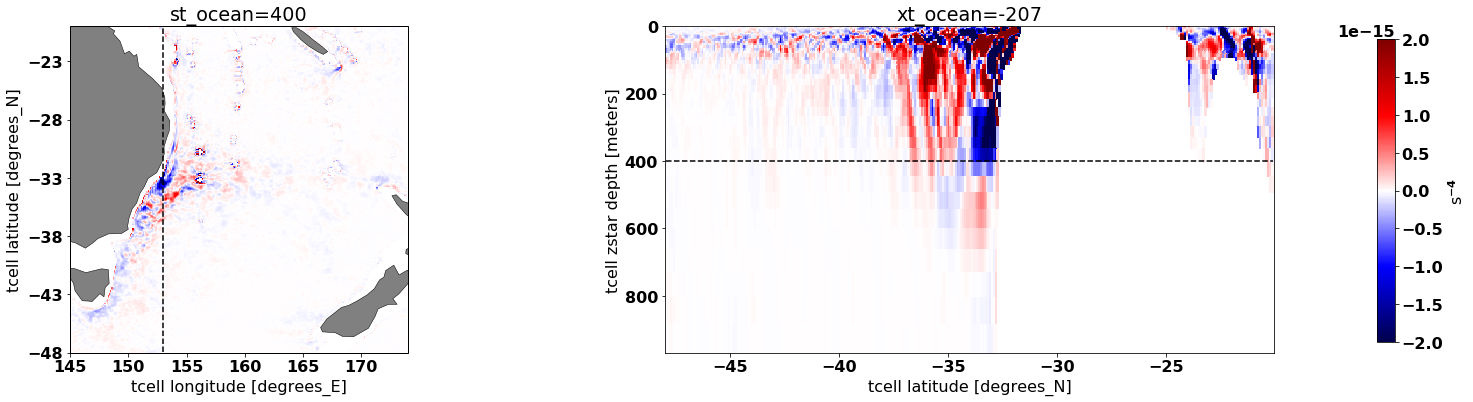

In [41]:
vmin=-2e-15
vmax=2e-15
d=400
fig=plt.figure(figsize=(24,6))
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_xticks(np.arange(eacx.start,eacx.stop+1,5)+360, crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(eacy.start,eacy.stop+1,5), crs=ccrs.PlateCarree())
#ax.streamplot(X, Y, U10_sl.values, V10_sl.values,density=1,color='k',linewidth=1)
p1=pv_ds_var.sel(st_ocean=d,method='nearest').plot(cmap='seismic',vmin=vmin,vmax=vmax,add_colorbar=False)
x0=pv_ds_var.sel(xt_ocean=153-360,method='nearest').xt_ocean.values
y0=pv_ds_var.yt_ocean.values
plt.plot(np.tile(x0+360,len(y0)),y0,'k--')
plt.title('st_ocean='+str(d))

ax1=plt.subplot(1,2,2)
pv_ds_var.sel(xt_ocean=153-360,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=vmin,vmax=vmax,yincrease=False,add_colorbar=False)
plt.plot(y0,np.tile(d,len(y0)),'k--')
plt.title('xt_ocean='+str(153-360))


ax3 = plt.axes([0.96,0.15,0.01,0.7])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('s$^{-4}$',fontsize=16)

## Plot

### Every 4 year separation $\overline{u}\cdot\overline{q}$

In [10]:
warnings.filterwarnings('ignore')
u = cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xu_ocean=eacx)\
                             .sel(yu_ocean=eacy)
v = cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xu_ocean=eacx)\
                             .sel(yu_ocean=eacy)
w=cc.get_nc_variable(expt,'ocean.nc','wt',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xt_ocean=eacx)\
                             .sel(yt_ocean=eacy)
pv = cc.get_nc_variable(expt,'ocean.nc','vert_pv',use_cache=True,
                             n=n_files,time_units=time_units,offset=offset)\
                             .sel(xt_ocean=eacx)\
                             .sel(yt_ocean=eacy)

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_vert_pv_None_days-since-0001-01-01_None_False.pkl


In [12]:
grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
dxu=grid.dxu.sel(xu_ocean=eacx)\
        .sel(yu_ocean=eacy)
dyu=grid.dyu.sel(xu_ocean=eacx)\
        .sel(yu_ocean=eacy)
xsize=pv.shape[3]#290
ysize=pv.shape[2]#345
zsize=pv.shape[1]#75
z=u.st_ocean.values
dz=z[1:]-z[0:-1]
dzdz=dz[1:]+dz[0:-1]
dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
dz3d=np.transpose(dz3d,(2,0,1))

In [13]:
def meands_pv_mf(u1,v1,w1,pv1):
    u=u1.mean('time')
    v=v1.mean('time')
    w=w1.mean('time')
    pv=pv1.mean('time')
    #u*(dq/dx)
    #print('computing udq_dx...')
    dq=pv.values[:,1:-1,2:]-pv.values[:,1:-1,0:-2]#(75, 343, 288)
    dxdx=dxu.values[:,1:-1]+dxu.values[:,2:]#(344, 288)
    dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])#(343, 288)
    dx3d=np.tile(dxdx_snmean,(75,1,1))#(75,343,288)
    uu=1/2*(u.values[:,:,1:-1]+u.values[:,:,2:])
    uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])#(75,343,288)
    udq_dx=uu_snmean*(dq/dx3d)
    Udq_dx=xr.DataArray(udq_dx,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    #v*(dq/dy)
    #print('computing udq_dy...')
    dqy=pv.values[:,2:,0:-1]-pv.values[:,0:-2,0:-1]
    dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
    dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
    vv=1/2*(v.values[:,0:-1,:]+v.values[:,1:,:])
    vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
    dy3d=np.tile(dy_wemean,(75,1,1))#(75, 343, 289)
    vdq_dy=vv_wemean*(dqy/dy3d)
    Vdq_dy=xr.DataArray(vdq_dy,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][0:-1]])#(75, 343, 289)
    #w*(dq/dz)
    #print('computing wdq_dz')
    wnew=w[:,1:-1,1:-1]
    qz=pv[:,1:-1,1:-1]
    dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
    w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
    wdq_dz=w_mean[0:-1,:,:]*(dqz/dz3d)
    Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
    #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)
    
    pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
    PV_DS_mean=xr.DataArray(pv_downstream,coords=[pv['st_ocean'][1:-1],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    return PV_DS_mean

In [14]:
times = [pd.to_datetime('1985', format='%Y')+pd.DateOffset(years=y) for y in range(0,34,4)]
tranges = list(zip(times[0:-1], times[1:]))
#tranges.append((times[0],times[-1]))  # also include range covering all requested time ranges

yearranges = [str(pd.to_datetime(t[0]).year)+'-'+str(pd.to_datetime(t[1]).year-1) for t in tranges]
tslices = {y:slice(*t) for y,t in zip(yearranges,tranges)}
tsliceall = slice(min(min(tranges)), max(max(tranges))) 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 1 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 2 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 3 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 4 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 5 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 6 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 7 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 8 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


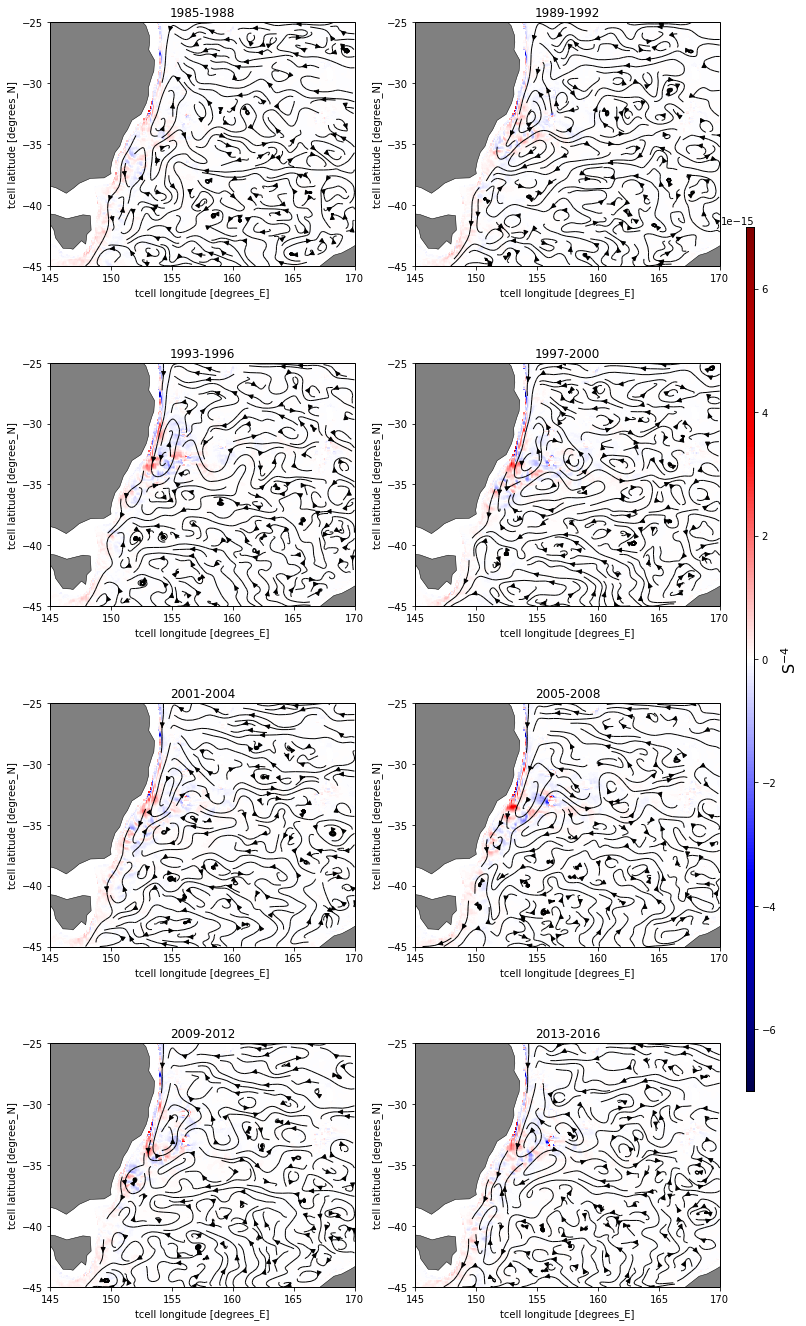

In [15]:
warnings.filterwarnings('ignore')
d=400
fig=plt.figure(figsize=(12,24))
#clev=np.arange(-7e-15,7e-15,1e-16)
for i, (yr,t) in enumerate(tslices.items()):
    u1=u.sel(time=t)
    v1=v.sel(time=t)
    w1=w.sel(time=t)
    pv1=pv.sel(time=t)
    PV_DS_mean=meands_pv_mf(u1,v1,w1,pv1)
    U10_sl=u1.mean('time').sel(st_ocean=d,method='nearest')
    V10_sl=v1.mean('time').sel(st_ocean=d,method='nearest')
    X,Y=np.meshgrid(U10_sl['xu_ocean'].values+360,V10_sl['yu_ocean'].values)
    print('plotting',i+1,'in',len(tslices.items()))
    ax=plt.subplot(4,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land)
    ax.set_extent(region,crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(eacx.start,eacx.stop+1,5)+360, crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(eacy.start,eacy.stop+1,5), crs=ccrs.PlateCarree())
    ax.streamplot(X,Y,U10_sl.values,V10_sl.values,density=1.5,color='k',linewidth=1)
    p1=PV_DS_mean.sel(st_ocean=d,method='nearest').plot(cmap='seismic', vmin=-7e-15,
                                                          vmax=7e-15,add_colorbar=False,
                                                          transform=ccrs.PlateCarree())
    plt.title(yr)
    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('S$^{-4}$',fontsize=16)
savefigure('downstreampv_eac')